In [1]:
# 图表库
%matplotlib inline
import matplotlib.pyplot as plt
# 深度学习
import tensorflow as tf
# 矩阵
import numpy as np
# sklearn的各种辅助小工具
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Normalizer

In [2]:
# 设置随机种子，这样每次得到的随机数结果都一样了
tf.set_random_seed(0)

In [3]:
# 读取数据集
X, y = load_boston(True)

In [4]:
# 把目标变量改变形状，相当于把一个一维向量转化为一个1xn维矩阵（当然还是向量）
y = y.reshape([len(y), 1])

In [5]:
# 分割测试集与训练集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [6]:
# 计算训练集的平均值和标准差
# 很必要，否则可能就无法拟合（当然也许可以修改参数初始化，减小学习率等方法解决）
mu = np.mean(X_train, axis=0)
sigma = np.std(X_train, axis=0)
# 把训练集标准化
X_train = (X_train - mu) / sigma

In [7]:
# 用训练集的参数标准化测试集（尽量不看测试集数据）
X_test = (X_test - mu) / sigma

In [8]:
# 训练集有404条数据，每条数据由13个变量组成，目标变量是一维的
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(404, 13) (102, 13) (404, 1) (102, 1)


In [9]:
# 训练集input的占位
X = tf.placeholder(tf.float32, [None, 13], name='X')
# 训练集target的占位
y = tf.placeholder(tf.float32, [None, 1], name='y')

In [10]:
# 输入层大小（变量数）
input_size = 13
# 输出层大小（变量数）
target_size = 1
# 隐藏层大小
hidden_size = 32

# RNN

这算是一种 Elman Network 参考[wiki](https://en.wikipedia.org/wiki/Recurrent_neural_network)

相当于下面的公式（改编自wiki）

$h_{t-1}$就是上一轮的隐藏状态$h$，对于第一轮来说就是全零

$h_{t} = tanh(h_{t-1}W_{h} + b_{h} + XW_{x} + b_{x})$

$y_{t} = h_{t}W_{y} + b_{y}$


In [11]:
# 与 X 相关的参数
Wx = tf.Variable(tf.random_normal([input_size, hidden_size]), name='weight_x')
bx = tf.Variable(tf.zeros([hidden_size]), name='bias_x')
# 与上一轮状态 h 相关的参数
Wh = tf.Variable(tf.random_normal([hidden_size, hidden_size]), name='weight_h')
bh = tf.Variable(tf.zeros([hidden_size]), name='bias_h')
# 与输出 y 相关的参数
Wy = tf.Variable(tf.random_normal([hidden_size, target_size]), name='weight_y')
by = tf.Variable(tf.zeros([target_size]), name='bias_y')
# 上一轮状态 h
h = tf.Variable(tf.zeros([target_size, hidden_size]), name='hidden')

In [12]:
h_ = tf.tanh(tf.add(
    tf.add(tf.matmul(h, Wh, name='mul_h_Wh'), bh, name='add_mul_h_Wh_bh'),
    tf.add(tf.matmul(X, Wx, name='mul_X_Wx'), bx, name='add_mul_X_Wx_bx'),
    name='add_h_x'
), name='tanh_h')

In [13]:
pred = tf.add(
    tf.matmul(h_, Wy, name='mul_h_Wy'),
    by,
    name='add_mul_h_Wy'
)

In [14]:
# 损失函数
cost = tf.reduce_mean(tf.square(tf.sub(pred, y, name='sub_pred_y'), name='square'), name='reduce_mean')

In [15]:
# 学习率，有时候也写作 alpha
learning_rate = 0.01
# 迭代次数
n_epoch = 400

In [16]:
# 定义一个tensorflow的优化算子（这应该叫啥？）
opt = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [17]:
# 初始化所有变量
init = tf.initialize_all_variables()

In [18]:
# disable GPU 关闭GPU支持，用不到……显存读写速度比内存慢得多，小数据反而慢
config = tf.ConfigProto(
    device_count = {'GPU': 0}
)

In [19]:
# 保存每次迭代的损失
costs = []
# 开一个tensorflow的session
with tf.Session(config=config) as sess:
    sess.run(init)
    # 开始迭代
    for epoch in range(n_epoch + 1):
        # feed_dict是我们要喂给tensorflow的数据，这条是训练梯度下降，应用opt算子
        sess.run(opt, feed_dict={X: X_train, y: y_train})
        # 这条是计算损失函数，应用cost算子
        c = sess.run(cost, feed_dict={X: X_train, y: y_train})
        # 保存历史损失
        costs.append(c)
        if epoch % 500 == 0:
            print('Epoch: {}, cost: {}'.format(epoch, c))
    # 计算训练集结果和测试集结果
    pred_train = sess.run(pred, feed_dict={X: X_train, y: y_train})
    pred_test = sess.run(pred, feed_dict={X: X_test, y: y_test})

Epoch: 0, cost: 157.44117736816406


In [20]:
# 训练集 Mean Squared Error
print('mse of train:', mean_squared_error(y_train, pred_train))

mse of train: 6.98397517045


In [21]:
# 测试集平均平方错误
print('mse of test:', mean_squared_error(y_test, pred_test))

mse of test: 23.8843873354


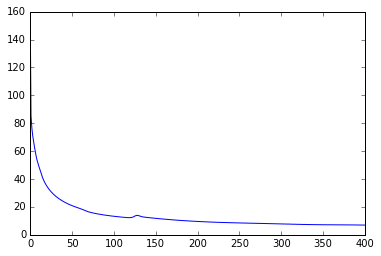

In [22]:
# 这张图是损失函数随着训练轮次增加而下降的图
plt.plot(list(range(len(costs))), costs)